# Disposition from Substance Use Treatment Programs

## Business Case

### Situation

### Background

### Assessment

### Findings

## Data

#### Source: 

 - The data for this analysis was obtained from the Substance Abuse and Mental Health Services Administration (SAMHSA), a sub-division of the Department of Health and Human Services (DHS)
 - The specific dataset is the Treatment Episode Data - Discharges for 2019. This dataset contains 1,722,503 records.  Each record represents a unique treatment episode for an individual.  The data is deidentified by SAMHSA to to meet HIPAA requirements.  https://www.samhsa.gov/data/report/treatment-episode-data-set-teds-2019-admissions
 - The data dictionary can be found here: https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/TEDS-D-2019/TEDS-D-2019-datasets/TEDS-D-2019-DS0001/TEDS-D-2019-DS0001-info/TEDS-D-2019-DS0001-info-codebook_V1.pdf
 
#### Exclusions/Inclusions: 
 
 * For the purpose of this study, 24 hour detox, and inpatient (hospital) therapy were excluded due to the abbreviate nature of the detox program and the inability of individuals to work or seek employment while an inpatient. The included programs are: \

    - **Ambulatory Outpatient Intensive Therapy** - Minimum treatment ≥ 2 hours of therapy per day at least 3 times per week
        - N = 235,640
    - **Ambulatory Outpatient Non-Intensive Therapy** - Frequency and duration of therapy is less than the Intensive program. 
        - N = 878,381
 

## Import Tools

In [107]:
import numpy as np
import pandas as pd
import xlrd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Import Data

In [32]:
df_TEDSD = pd.read_csv('/Users/dolant98/Documents/Flatiron/Projects/Data/tedsd_puf_2019.csv')

## Assessment of data cleanliness

### Columns and data types:

In [33]:
df_TEDSD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722503 entries, 0 to 1722502
Data columns (total 76 columns):
 #   Column                 Dtype
---  ------                 -----
 0   DISYR                  int64
 1   CASEID                 int64
 2   STFIPS                 int64
 3   CBSA2010               int64
 4   EDUC                   int64
 5   MARSTAT                int64
 6   SERVICES               int64
 7   DETCRIM                int64
 8   LOS                    int64
 9   PSOURCE                int64
 10  NOPRIOR                int64
 11  ARRESTS                int64
 12  EMPLOY                 int64
 13  METHUSE                int64
 14  PSYPROB                int64
 15  PREG                   int64
 16  GENDER                 int64
 17  VET                    int64
 18  LIVARAG                int64
 19  DAYWAIT                int64
 20  SERVICES_D             int64
 21  REASON                 int64
 22  EMPLOY_D               int64
 23  LIVARAG_D              int64
 24

**NOTE:** 
- The data has already been converted to numeric values and labeled (see data dictionary).  This takes care of some of the pre-processing steps.  

- The number of records matches the expected number based on the supporting documentation linked above.  

### Missing/Null/ and Dummy Values

The next step is to assess if there are any null values in the df_TEDSD dataframe.  

In [34]:
df_TEDSD.isnull().values.any()

False

**Note** While there are no null values, there is a dummy (placeholder) value of "-9" which is used to indicate that the data was not collected, is not known, or is not applicable for the individual.  

In [35]:
df_TEDSD[df_TEDSD.isin([-9]).any(axis = 1)].head()

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,NOPRIOR,ARRESTS,EMPLOY,METHUSE,PSYPROB,PREG,GENDER,VET,LIVARAG,DAYWAIT,SERVICES_D,REASON,EMPLOY_D,LIVARAG_D,ARRESTS_D,DSMCRIT,AGE,RACE,ETHNIC,DETNLF,DETNLF_D,PRIMINC,SUB1,SUB2,SUB3,SUB1_D,SUB2_D,SUB3_D,ROUTE1,ROUTE2,ROUTE3,FREQ1,FREQ2,FREQ3,FREQ1_D,FREQ2_D,FREQ3_D,FRSTUSE1,FRSTUSE2,FRSTUSE3,HLTHINS,PRIMPAY,FREQ_ATND_SELF_HELP,FREQ_ATND_SELF_HELP_D,ALCFLG,COKEFLG,MARFLG,HERFLG,METHFLG,OPSYNFLG,PCPFLG,HALLFLG,MTHAMFLG,AMPHFLG,STIMFLG,BENZFLG,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2019,20191553576,2,-9,4,1,7,-9,37,1,0,0,2,2,1,2,2,2,3,0,7,1,2,3,0,19,4,1,4,-9,-9,1,2,1,1,2,1,1,1,-9,-9,2,-9,-9,2,-9,-9,5,-9,-9,3,7,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,0,1
1,2019,20191465214,2,-9,3,1,7,-9,35,1,0,0,1,2,1,2,2,2,3,0,7,3,1,3,0,4,5,1,4,-9,-9,1,2,4,1,2,4,1,1,2,-9,2,3,-9,2,2,-9,3,3,-9,3,7,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,0,3
2,2019,20191443889,2,-9,2,1,7,-9,35,1,0,0,4,2,1,2,2,2,3,0,7,3,4,3,0,19,1,8,4,2,2,4,2,4,1,2,4,1,1,2,-9,2,2,-9,2,2,-9,2,2,-9,2,4,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,0,3
3,2019,20191409377,2,-9,3,1,7,-9,37,1,1,0,3,2,1,2,2,2,3,0,7,1,3,3,0,4,5,1,4,-9,-9,4,2,5,4,2,5,4,1,2,2,1,1,1,1,3,1,3,5,3,3,7,4,4,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,0,3
4,2019,20191479567,2,-9,3,3,7,-9,37,1,1,0,4,2,1,2,2,2,3,0,7,3,4,3,0,4,11,8,4,3,3,4,2,1,1,2,1,1,1,-9,-9,1,-9,-9,1,-9,-9,7,-9,-9,3,7,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,0,1


In [36]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

**Note:** The output below shows the list of columns the corresponding count of rows with a dummy value of '-9'.  
There are many columns for which '-9' accounts for a majority of the records.  The data dictionary/codebook explains that if the column is not relevant for the individual (i.e. - Pregnancy Status), the dummy value is used. 

In [37]:
display(df_TEDSD[df_TEDSD == -9].count().sort_values(ascending = False))

FREQ3_D                  1441000
DETCRIM                  1397909
FREQ3                    1372001
FRSTUSE3                 1371909
ROUTE3                   1362519
DETNLF_D                 1332282
DETNLF                   1251911
FREQ2_D                  1183470
PREG                     1136767
PRIMPAY                   989974
DAYWAIT                   920756
HLTHINS                   868565
FRSTUSE2                  844104
FREQ2                     818003
ROUTE2                    817221
CBSA2010                  704011
PRIMINC                   680082
FREQ1_D                   537124
DSMCRIT                   410311
FREQ_ATND_SELF_HELP_D     376995
MARSTAT                   360937
LIVARAG_D                 354754
ARRESTS_D                 340163
FREQ_ATND_SELF_HELP       327054
EMPLOY_D                  322858
PSYPROB                   225375
SUB1_D                    217220
FREQ1                     196872
SUB3                      185870
ARRESTS                   182116
METHUSE   

**Employment** - In the case of employment status upon admission to the program, there are a total of 152,365 where this information is not known. This represents 9% of the total population.  

In [38]:
df_TEDSD['EMPLOY'].value_counts(normalize = True).sort_values(ascending = True)

 2    0.065444
-9    0.088456
 1    0.162323
 4    0.315197
 3    0.368580
Name: EMPLOY, dtype: float64

### Columns to drop

- DISYR is the discharge year and is always = 2019 in this dataframe.  
- CASEID is the unique identifier representing treatment episode encounter.  Since the index also acts as a unique identifier, the CASEID will be dropped.  

Dropping these two columns will avoid any skewing when scaling the data

In [39]:
df_TEDSD_staging = df_TEDSD.drop(['DISYR','CASEID'], axis = 1)

### Create a subset of the dataframe for Outpatient Therapy

In order to have comparable population, the 24-hour Detox and Inpatient Treatment Episodes should be excluded.  Based on the documentation on page 33 of the dictionary/codebook, the expected number of records for *SERVICE 6 (Ambulatory - Intensive Outpatient)* and *7 (Ambulatory, Non-intensive Outpatient)* are *878,381* and *235,640* respectively.    

In [57]:
df_TEDSD_staging['SERVICES'].value_counts()

7    878381
2    245663
6    235640
4    180040
5    121580
1     43961
8     13292
3      3946
Name: SERVICES, dtype: int64

Since the counts for the two outpatient categories have been confirmed, a subset of the dataframe is created: **"td_ted_out"**

In [58]:
df_ted_out = df_TEDSD_staging[df_TEDSD['SERVICES'].isin([6,7])]

Based on the number of rows in SERVICE 6 and 7, the number of rows in df_ted_out should = 1,114,021

In [42]:
df_ted_out.shape

(1114021, 74)

#### Re-evaluate dummy value frequency in subset

In [43]:
display(df_ted_out[df_ted_out == -9].count().sort_values(ascending = False))

FREQ3_D                  937839
FREQ3                    901600
FRSTUSE3                 900053
DETNLF_D                 897919
ROUTE3                   895315
DETNLF                   883080
DETCRIM                  855739
FREQ2_D                  774124
PREG                     698474
DAYWAIT                  647995
PRIMPAY                  591304
FRSTUSE2                 576455
FREQ2                    563112
ROUTE2                   562169
HLTHINS                  545238
CBSA2010                 511493
PRIMINC                  502579
FREQ1_D                  372125
FREQ_ATND_SELF_HELP_D    312196
LIVARAG_D                244513
DSMCRIT                  236385
ARRESTS_D                232964
MARSTAT                  222671
EMPLOY_D                 213229
FREQ_ATND_SELF_HELP      199385
FREQ1                    166825
LIVARAG                  156197
EDUC                     156149
VET                      154995
SUB1_D                   136798
FRSTUSE1                 134768
EMPLOY  

There are still a substantial number of columns and rows with dummy values.  The columns with the most are those which do not apply to all individuals in the treatment program.  For example, the columns which start with sub2, sub3, freq2, freq3, pertain to secondary and tertiary drugs that the individual is using.  If the individual is using only one drug, these columns will contain a -9 in these columns.  

## Baseline Model

### Train/Test Split 
- Train Test split using a test size of 33% and Random State = 42

In [44]:
# Defining X and y
X = df_ted_out.drop('REASON', axis = 1)
y = df_ted_out['REASON']

# Train-test split
# Set test_size=0.33 and random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,
                                                   random_state=42)


### Scaling and Transforming Data
- X_train is also fitted

In [45]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Review distribution of target (y_train)

In [46]:
y_train.value_counts(normalize = True)

1    0.350421
2    0.273278
4    0.240570
3    0.062616
7    0.048417
5    0.021624
6    0.003075
Name: REASON, dtype: float64

The output above shows:
   
   - **Completed Treatment** - 35% of the individuals completed treatment 
   - **Attrition** - 33% dropped out of the program or were terminated by the facility (categories 2 and 3), 
   - **Transferred** - 24% were transferred to another program, 
   - **Other** - the remaining 8% were incarcerated, died, or left the program for 'other' reasons.   

#### Logistic Regression

In [47]:
logreg = LogisticRegression(random_state = 42, max_iter = 1000)
logreg.fit(X_train_scaled, y_train)
display(logreg.score(X_train_scaled, y_train))
display(logreg.score(X_test_scaled, y_test))

0.6234307885647526

0.6235613815089751

##### Output 

The score is low at 62%, however it is very close across the train and test data which implies that the model is not overfitting.  The number of REASON categories may be making it difficult for the model to predict the outcome.  As a first step, I will consolidate the 7 categories into 3.  

## Refining the dataframe - Part I

 ### Update to REASON (target) classification

In [48]:
y_test.value_counts(normalize = True)

1    0.349313
2    0.274838
4    0.240371
3    0.062449
7    0.048193
5    0.021758
6    0.003076
Name: REASON, dtype: float64

The distribution of REASON in the y_test file is similar to the distribution in y_train.  That said, the number of categories and lower frequencies for some of them may be weakening the model.  As a result, I will update the REASON classfication to a more concise grouping.  

The new grouping is below: 

 - 1 - Complete ---> 1 - Complete
 - 2 - Dropped Out ---> 2 - Incomplete
 - 3 - Terminated ---> 2 - Incomplete
 - 4 - Transferred ---> 3 - Other
 - 5 - Incarcerated ---> 3 - Other
 - 6 - Death ---> 3 - Other
 - 7 - Other ---> 3 - Other

The code below is creating and updating a new column to reflect the mapping of REASON codes above. 

In [67]:
outcome = []

for reason in df_ted_out['REASON']:
    if reason == 1:   
        outcome.append(1)
    elif reason == 2: 
        outcome.append(2)
    elif reason == 3: 
        outcome.append(2)    
    else:           
        outcome.append(3)

In [71]:
df_ted_out['OUTCOME'] = outcome

<ipython-input-71-cb498fb9e484>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ted_out['OUTCOME'] = outcome


In [72]:
df_ted_out['OUTCOME'].head(10)

0    1
1    2
2    2
3    1
4    2
5    2
6    3
7    1
8    2
9    2
Name: OUTCOME, dtype: int64

## Re-running the model - Part I

### Updated Logistic Regression

#### Train/Test Split 

Defining X and y.  Note that columns OUTCOME and REASON are dropped when creating X.  

In [73]:
# Defining X and y
X = df_ted_out.drop(['OUTCOME','REASON'], axis = 1)
y = df_ted_out['OUTCOME']

# Train-test split
# Set test_size=0.33 and random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,
                                                   random_state=42)

#### Scaling and Transforming Data

In [74]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Distribution of  y (target) variable

In [75]:
y_train.value_counts(normalize = True)

1    0.350421
2    0.335894
3    0.313686
Name: OUTCOME, dtype: float64

Note that the three targets are evenly distributed

#### Run logistic regression

In [77]:
logreg = LogisticRegression(random_state = 42, max_iter = 10000)
logreg.fit(X_train_scaled, y_train)
display(logreg.score(X_train_scaled, y_train))
display(logreg.score(X_test_scaled, y_test))

0.6584069539680115

0.6572476994344811

The score improved only slightly.  

## Refining the dataframe - Part II

### Create subset of dataframe to reflect completed or not completed outcomes

In [80]:
df_ted_binary = df_ted_out[df_ted_out['OUTCOME'] != 3]

In [82]:
df_ted_binary.shape

(764674, 75)

### Assessing distribution of age and # of episodes pertaining to minors

In [ ]:
df_ted_binary.sort_values(['AGE']).value_counts()

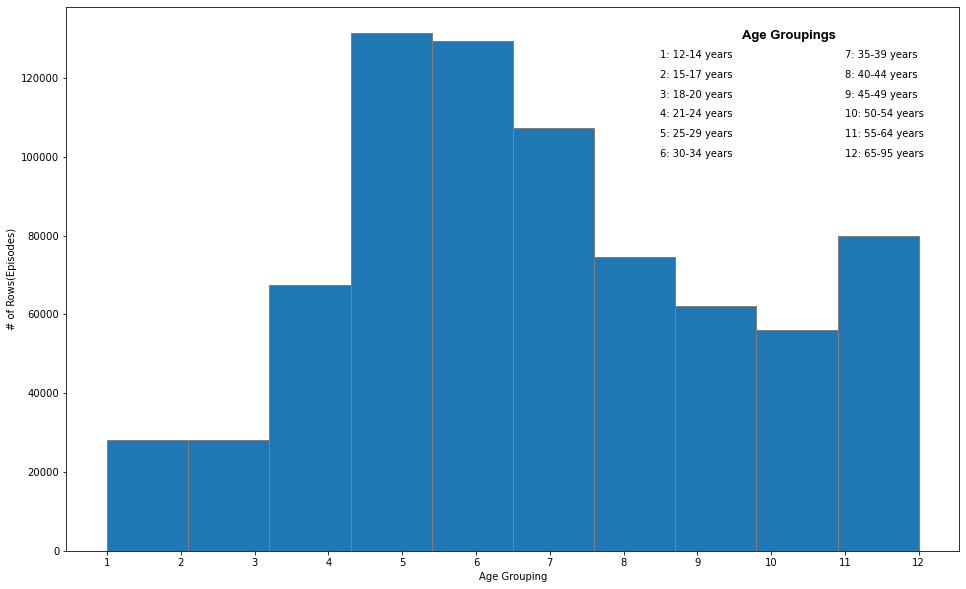

In [165]:
plt.figure(figsize = (16,10))
ax = plt.axes()

plt.xlabel("Age Grouping")
plt.ylabel("# of Rows(Episodes)")
plt.hist(df_ted_binary["AGE"], edgecolor = "gray")
  
plt.text(9.6, 130000, "Age Groupings", fontname="Arial", fontweight="bold", fontsize = 13)
plt.text(8.5, 125000, "1: 12-14 years")
plt.text(8.5, 120000, "2: 15-17 years")
plt.text(8.5, 115000, "3: 18-20 years")
plt.text(8.5, 110000, "4: 21-24 years")
plt.text(8.5, 105000, "5: 25-29 years")
plt.text(8.5, 100000, "6: 30-34 years")
plt.text(11, 125000, "7: 35-39 years")
plt.text(11, 120000, "8: 40-44 years")
plt.text(11, 115000, "9: 45-49 years")
plt.text(11, 110000, "10: 50-54 years")
plt.text(11, 105000, "11: 55-64 years")
plt.text(11, 100000, "12: 65-95 years")

plt.xticks(np.arange(1, 12.5, 1))
plt.show()

The chart above shows the distribution of Treatment Episodes by age group.  

In [166]:
age_lt_18 = len(df_ted_binary[(df_ted_binary['AGE']==1) | (df_ted_binary['AGE']==2)])
print("The number of episodes for individuals younger than 18 is: ","{:,}".format(age_lt_18))

The number of episodes for individuals younger than 18 is:  28,112


Given the focus on employment and housing, and the added complexity of consent for minors, the rows pertaining to individuals younger than 18 years of age will be removed.

In [167]:
df_ted_binary_gt_17 = df_ted_binary[df_ted_binary['AGE']>2]

In [168]:
df_ted_binary_gt_17.shape

(736562, 75)

In [169]:
# Defining X and y
X = df_ted_binary_gt_17.drop(['OUTCOME','REASON'], axis = 1)
y = df_ted_binary_gt_17['OUTCOME']

# Train-test split
# Set test_size=0.33 and random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,
                                                   random_state=42)

In [170]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [171]:
y_train.value_counts(normalize = True)

1    0.511443
2    0.488557
Name: OUTCOME, dtype: float64

In [172]:
logreg = LogisticRegression(random_state = 42, max_iter = 10000)
logreg.fit(X_train_scaled, y_train)
display(logreg.score(X_train_scaled, y_train))
display(logreg.score(X_test_scaled, y_test))

0.7638562419958824

0.7643068137872018